# Импортирование необходимых библиотек

In [1]:
import os
import uuid
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
import torchvision.models as models
import onnx
from tqdm import tqdm
import numpy as np
from PIL import Image
import pickle
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

In [2]:
# Проверка наличия CUDA
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if device.type == 'cuda':
    print("CUDA is available!")
    print(f"Device name: {torch.cuda.get_device_name(0)}")
    print(f"CUDA capability: {torch.cuda.get_device_capability(0)}")
    print(f"Driver version: {torch.version.cuda}")
    print(f"Device count: {torch.cuda.device_count()}")
    print(f"Current device: {torch.cuda.current_device()}")
else:
    print("CUDA is not available. Running on CPU.")

CUDA is not available. Running on CPU.


/home/redalexdad/.local/lib/python3.11/site-packages/torch/cuda/__init__.py:118: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


# Загрузка и распаковка набора данных CIFAR100

In [ ]:
filename = "cifar-100-python.tar.gz"

if not os.path.exists(filename):
    # Файла нет, скачиваем
    !wget https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz
else:
    print(f"Файл '{filename}' уже существует.")

# Распаковываем архив, если он не был распакован ранее
if not os.path.exists("cifar-100-python"):
    !tar -xvzf cifar-100-python.tar.gz
else:
    print("Архив уже распакован.")

## Архитектуры модели

### Класс модели CIFAR100

In [42]:
class CIFAR100Trainer:
    def __init__(self, classes, batch_size=128, lr_rate=1e-4, criterion=nn.CrossEntropyLoss()):
        self.classes = classes
        self.batch_size = batch_size
        self.lr_rate = lr_rate
        self.device = self.check_device()
        self.criterion = criterion
        self.history = {"epoch": [], "loss": []}  # История обучения
        # Загрузка названий классов
        self.class_names = self.load_class_names()
        
        # Чтение тренировочной выборки (обучающих данных)
        with open('cifar-100-python/train', 'rb') as f:
            data_train = pickle.load(f, encoding='latin1')

        # Чтение тестовой выборки (тестовых данных)
        with open('cifar-100-python/test', 'rb') as f:
            data_test = pickle.load(f, encoding='latin1')

        # Фильтрация данных и создание датасетов
        self.train_dataset = self.prepare_data(data_train, 'train')
        self.test_dataset = self.prepare_data(data_test, 'test')

        # Загрузка данных в батчи
        self.train_loader = DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)
        self.test_loader = DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False)
        
    def load_class_names(self):
        """Загружает названия классов из мета-файла."""
        with open('cifar-100-python/meta', 'rb') as f:
            meta = pickle.load(f, encoding='latin1')
        return meta['fine_label_names']

    def prepare_data(self, data, part):
        """Фильтрация данных и преобразование в TensorDataset."""
        X = data['data'].reshape(-1, 3, 32, 32)  # Данные в формате NCHW
        X = np.transpose(X, [0, 2, 3, 1]) # NCHW -> NHWC
        y = np.array(data['fine_labels'])

        mask = np.isin(y, self.classes)
        X = X[mask].copy()
        y = y[mask].copy()
        y = np.unique(y, return_inverse=1)[1]

        tensor_x = torch.Tensor(X)
        tensor_y = F.one_hot(torch.Tensor(y).to(torch.int64), num_classes=len(self.classes)) / 1.
        dataset = TensorDataset(tensor_x, tensor_y)
        return dataset
        
    def train(self, model, epochs=10):
        model = model.to(self.device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=self.lr_rate)
        self.history = {"epoch": [], "loss": []}  # Инициализация истории

        for epoch in range(epochs):
            model.train()  # Установка модели в режим обучения
            running_loss = 0.0

            progress_bar = tqdm(self.train_loader, desc=f'Epoch {epoch+1}/{epochs}', unit="batch")
            for batch_idx, (data, target) in enumerate(progress_bar):
                data, target = data.to(self.device), target.to(self.device)
                optimizer.zero_grad()
                # Вызов метода forward() модели
                output = model.forward(data) 
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                progress_bar.set_postfix(loss=f"{loss:.6f}")
                
            average_loss = running_loss / len(self.train_loader)
            self.history["epoch"].append(epoch + 1)
            self.history["loss"].append(average_loss)  # Сохранение средней потери

            print(f'Epoch: {epoch+1}/{epochs}, Loss: {running_loss/len(self.train_loader):.6f}')

    def evaluate(self, model):
        model = model.to(self.device)
        model.eval()  # Установка модели в режим оценки
        
        # Обрабатываем обе выборки: тренировочную и тестовую
        dataloaders = {'train': self.train_loader, 'test': self.test_loader}
        
        for part in ['train', 'test']:
            all_predicted = []
            all_target = []
            with torch.no_grad():
                for data, target in dataloaders[part]:
                    data, target = data.to(self.device), target.to(self.device)
                    output = model(data)
                    
                    # Получаем предсказания
                    _, predicted = torch.max(output.data, 1)
                    
                    # Преобразуем target обратно в одномерный тензор
                    target_indices = torch.argmax(target, dim=1)
                    
                    all_predicted.extend(predicted.cpu().numpy())
                    all_target.extend(target_indices.cpu().numpy())
            
            # Преобразуем списки в массивы NumPy
            all_predicted = np.array(all_predicted)
            all_target = np.array(all_target)
            
            # Выводим наименования классов для выбранных индексов
            selected_class_names = [self.class_names[i] for i in self.classes]
            
            # Выводим отчет о классификации
            print(f"Classification report for {part} dataset:")
            report = classification_report(all_target, all_predicted, target_names=selected_class_names, zero_division=0, digits=4)
            print(report)
            print('-' * 50)

    def save_model(self, model, path='models/'):
        # Генерируем уникальный идентификатор
        unique_id = str(uuid.uuid4())  # Генерация уникального ID
        model_name = f"cifar100_{unique_id}.onnx"  # Формируем название модели
        
        # Создаем полный путь для сохранения модели
        filepath = os.path.join(path, model_name)  # Корректное соединение пути и имени файла
        
        # Убедимся, что директория для сохранения существует
        os.makedirs(path, exist_ok=True)  # Создаем директорию, если она не существует

        # Входной тензор для модели (с учетом правильного порядка: (N, H, W, C))
        dummy_input = torch.randn(1, 32, 32, 3, requires_grad=True).to(self.device)  # (N, H, W, C)
    
        # Экспорт модели
        torch.onnx.export(
            model,               # модель
            dummy_input,         # входной тензор
            filepath,            # куда сохранить
            export_params=True,  # сохраняет веса обученных параметров внутри файла модели
            opset_version=9,    # версия ONNX
            do_constant_folding=True,  # следует ли выполнять укорачивание констант для оптимизации
            input_names=['input'],    # имя входного слоя
            output_names=['output'],   # имя выходного слоя
            dynamic_axes={'input': {0: 'batch_size'},    # динамичные оси
                          'output': {0: 'batch_size'}}
        )
        
        # Вывод информации о сохраненной модели
        print(f"Model saved as: {model_name}")
        print(f"Model UUID: {unique_id}")

    def check_device(self):
        """Проверяет доступность CUDA и возвращает устройство."""
        if torch.cuda.is_available():
            device = 'cuda'
        else:
            device = 'cpu'
        print(f'Используемое устройство: {device}')
        return device

    def plot_training_history(self):
        fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    
        # Преобразуем список эпох для оси X
        epochs = self.history["epoch"]
    
        # Первый график: Полная история
        axs[0].plot(epochs, self.history["loss"], marker='o', linestyle='-', color='b', markersize=5, label='Loss')
        axs[0].set_xlabel('Epoch')
        axs[0].set_ylabel('Average Loss')
        axs[0].set_title('Loss Function (Full History)')
        axs[0].grid(True)
        axs[0].legend()
    
        # Второй график: Половина истории
        mid_index = len(epochs) // 2
        axs[1].plot(epochs[mid_index:], self.history["loss"][mid_index:], marker='o', linestyle='-', color='b', markersize=5, label='Loss')
        axs[1].set_xlabel('Epoch')
        axs[1].set_ylabel('Average Loss')
        axs[1].set_title('Loss Function (Second Half of Training)')
        axs[1].grid(True)
        axs[1].legend()
    
        plt.tight_layout()
        plt.show()

    def load_class_names(self):
        """Загружает названия классов из мета-файла."""
        with open('cifar-100-python/meta', 'rb') as f:
            meta = pickle.load(f, encoding='latin1')
        return meta['fine_label_names']
    
    def display_images_with_predictions(self, model, image_dir='./images'):
        """Отображает изображения и предсказания модели с процентным соотношением для заданных классов."""
        # Определение преобразований для входных изображений
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Пример нормализации, может потребоваться адаптация
        ])
    
        # Создаем отображение названий классов для выбранных индексов
        selected_class_names = [self.class_names[i] for i in self.classes]
    
        # Получаем список изображений
        images = [img for img in os.listdir(image_dir) if img.endswith(('jpg', 'png', 'jpeg'))]
        predictions = []
        probabilities = []
    
        for img_name in images:
            img_path = os.path.join(image_dir, img_name)
            img = Image.open(img_path).convert('RGB')  # Открываем изображение
            img_tensor = transform(img).unsqueeze(0).to(self.device)  # Применяем преобразования и добавляем размерность батча
            
            # Получаем предсказание модели
            with torch.no_grad():
                output = model(img_tensor)
                probs = torch.softmax(output, dim=1)  # Вычисляем вероятности
                predicted = torch.argmax(probs).item()  # Предсказанный класс
                predictions.append(predicted)  # Сохраняем предсказание
                probabilities.append(probs.squeeze().cpu().numpy())  # Сохраняем вероятности
    
        # Визуализация
        num_images = len(images)
        cols = 3
        rows = (num_images + cols - 1) // cols  # Вычисляем количество строк
        
        fig, axs = plt.subplots(rows, cols, figsize=(15, 5 * rows))
        axs = axs.flatten()  # Упрощаем доступ к осям
    
        for i, img_name in enumerate(images):
            img_path = os.path.join(image_dir, img_name)
            img = Image.open(img_path)
            axs[i].imshow(img)
            
            # Выводим предсказания и вероятности для выбранных классов
            title_text = f'Predicted: {self.class_names[predictions[i]]} (ID: {predictions[i]})\n'
            for cls in self.classes:
                # Получаем индекс и название класса
                if cls < len(probabilities[i]):
                    title_text += f'{selected_class_names[self.classes.index(cls)]}: {probabilities[i][cls] * 100:.2f}%, '
    
            axs[i].set_title(title_text[:-2])  # Убираем последний запятую
            axs[i].axis('off')  # Скрываем оси
    
        # Удаляем пустые оси, если их больше чем изображений
        for j in range(i + 1, len(axs)):
            axs[j].axis('off')
    
        plt.tight_layout()
        plt.show()

### Нормализация

In [43]:
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.tensor(mean)
        self.std = torch.tensor(std)

    def forward(self, input):
        x = input / 255.0
        x = x - self.mean
        x = x / self.std
        return torch.flatten(x, start_dim=1) # nhwc -> nm

#### Создание архитектуры модели

In [45]:
class CIFAR100Model(nn.Module):
    def __init__(self, hidden_layers=[64, 128, 64], num_classes=100):
        super(CIFAR100Model, self).__init__()
        self.norm = Normalize([0.5074, 0.4867, 0.4411], [0.2011, 0.1987, 0.2025])
        
        # Определяем входной размер (например, CIFAR100 имеет изображения размером 32x32x3)
        input_size = 32 * 32 * 3

        # Динамически создаем слои на основе переданного списка hidden_layers
        layers = []
        in_features = input_size
        for i, hidden_size in enumerate(hidden_layers):
            layers.append(nn.Linear(in_features, hidden_size))
            layers.append(nn.ReLU())  # Активационная функция
            in_features = hidden_size

        # Добавляем последний слой для классификации
        layers.append(nn.Linear(in_features, num_classes))

        # Создаем последовательность слоев
        self.seq = nn.Sequential(*layers)

    def forward(self, input):
        x = self.norm(input)
        return self.seq(x)

## Установки параметров

### По варианту

In [46]:
CLASSES = [94, 21, 51]

## Машинное обучение 

### Эксперимент №1

#### Гиперпараметры

In [49]:
batch_size=2**5
epochs=50
criterion=nn.NLLLoss()
lr_rate = 1e-2
layers=[2**4, 2**6, 2**4]

#### Инициализация модели

In [50]:
%%time
trainer = CIFAR100Trainer(CLASSES, batch_size, lr_rate)

Используемое устройство: cpu
CPU times: user 185 ms, sys: 422 ms, total: 606 ms
Wall time: 510 ms


In [51]:
%%time
cifar100_001 = CIFAR100Model(layers, CLASSES.__len__())

CPU times: user 1.71 ms, sys: 1.03 ms, total: 2.74 ms
Wall time: 1.46 ms


#### Информация о модели

In [52]:
cifar100_001

CIFAR100Model(
  (norm): Normalize()
  (seq): Sequential(
    (0): Linear(in_features=3072, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=16, bias=True)
    (5): ReLU()
    (6): Linear(in_features=16, out_features=3, bias=True)
  )
)

#### Обучение

In [53]:
%%time
trainer.train(cifar100_001, epochs)

Epoch 1/50: 100%|█| 47/47 [00:00<00:00, 244.21batch/s, loss=0.75046


Epoch: 1/50, Loss: 0.852019


Epoch 2/50: 100%|█| 47/47 [00:00<00:00, 261.67batch/s, loss=0.72391


Epoch: 2/50, Loss: 0.609201


Epoch 3/50: 100%|█| 47/47 [00:00<00:00, 256.88batch/s, loss=0.45361


Epoch: 3/50, Loss: 0.519508


Epoch 4/50: 100%|█| 47/47 [00:00<00:00, 278.63batch/s, loss=0.30059


Epoch: 4/50, Loss: 0.502956


Epoch 5/50: 100%|█| 47/47 [00:00<00:00, 279.10batch/s, loss=0.31375


Epoch: 5/50, Loss: 0.457708


Epoch 6/50: 100%|█| 47/47 [00:00<00:00, 273.63batch/s, loss=0.23605


Epoch: 6/50, Loss: 0.378284


Epoch 7/50: 100%|█| 47/47 [00:00<00:00, 268.95batch/s, loss=0.48047


Epoch: 7/50, Loss: 0.373778


Epoch 8/50: 100%|█| 47/47 [00:00<00:00, 276.45batch/s, loss=0.23789


Epoch: 8/50, Loss: 0.377484


Epoch 9/50: 100%|█| 47/47 [00:00<00:00, 254.90batch/s, loss=0.24998


Epoch: 9/50, Loss: 0.304725


Epoch 10/50: 100%|█| 47/47 [00:00<00:00, 192.32batch/s, loss=0.4152


Epoch: 10/50, Loss: 0.310058


Epoch 11/50: 100%|█| 47/47 [00:00<00:00, 227.45batch/s, loss=0.3094


Epoch: 11/50, Loss: 0.336075


Epoch 12/50: 100%|█| 47/47 [00:00<00:00, 252.85batch/s, loss=0.2675


Epoch: 12/50, Loss: 0.293278


Epoch 13/50: 100%|█| 47/47 [00:00<00:00, 256.73batch/s, loss=0.1680


Epoch: 13/50, Loss: 0.231935


Epoch 14/50: 100%|█| 47/47 [00:00<00:00, 263.08batch/s, loss=0.2670


Epoch: 14/50, Loss: 0.202036


Epoch 15/50: 100%|█| 47/47 [00:00<00:00, 248.78batch/s, loss=0.0945


Epoch: 15/50, Loss: 0.169228


Epoch 16/50: 100%|█| 47/47 [00:00<00:00, 271.30batch/s, loss=0.2031


Epoch: 16/50, Loss: 0.160338


Epoch 17/50: 100%|█| 47/47 [00:00<00:00, 271.15batch/s, loss=0.2925


Epoch: 17/50, Loss: 0.170713


Epoch 18/50: 100%|█| 47/47 [00:00<00:00, 250.73batch/s, loss=0.0794


Epoch: 18/50, Loss: 0.175071


Epoch 19/50: 100%|█| 47/47 [00:00<00:00, 261.62batch/s, loss=0.3215


Epoch: 19/50, Loss: 0.160664


Epoch 20/50: 100%|█| 47/47 [00:00<00:00, 271.40batch/s, loss=0.1617


Epoch: 20/50, Loss: 0.133473


Epoch 21/50: 100%|█| 47/47 [00:00<00:00, 269.69batch/s, loss=0.2122


Epoch: 21/50, Loss: 0.159739


Epoch 22/50: 100%|█| 47/47 [00:00<00:00, 269.43batch/s, loss=0.0693


Epoch: 22/50, Loss: 0.146746


Epoch 23/50: 100%|█| 47/47 [00:00<00:00, 278.67batch/s, loss=0.2400


Epoch: 23/50, Loss: 0.149780


Epoch 24/50: 100%|█| 47/47 [00:00<00:00, 274.71batch/s, loss=0.1603


Epoch: 24/50, Loss: 0.180428


Epoch 25/50: 100%|█| 47/47 [00:00<00:00, 273.95batch/s, loss=0.2476


Epoch: 25/50, Loss: 0.208799


Epoch 26/50: 100%|█| 47/47 [00:00<00:00, 278.76batch/s, loss=0.2935


Epoch: 26/50, Loss: 0.126010


Epoch 27/50: 100%|█| 47/47 [00:00<00:00, 273.95batch/s, loss=0.0805


Epoch: 27/50, Loss: 0.105091


Epoch 28/50: 100%|█| 47/47 [00:00<00:00, 276.35batch/s, loss=0.5035


Epoch: 28/50, Loss: 0.166386


Epoch 29/50: 100%|█| 47/47 [00:00<00:00, 276.35batch/s, loss=0.2468


Epoch: 29/50, Loss: 0.167841


Epoch 30/50: 100%|█| 47/47 [00:00<00:00, 269.32batch/s, loss=0.0329


Epoch: 30/50, Loss: 0.127593


Epoch 31/50: 100%|█| 47/47 [00:00<00:00, 264.22batch/s, loss=0.1142


Epoch: 31/50, Loss: 0.122603


Epoch 32/50: 100%|█| 47/47 [00:00<00:00, 274.62batch/s, loss=0.0242


Epoch: 32/50, Loss: 0.079320


Epoch 33/50: 100%|█| 47/47 [00:00<00:00, 257.38batch/s, loss=0.0715


Epoch: 33/50, Loss: 0.113978


Epoch 34/50: 100%|█| 47/47 [00:00<00:00, 238.67batch/s, loss=0.4699


Epoch: 34/50, Loss: 0.154169


Epoch 35/50: 100%|█| 47/47 [00:00<00:00, 261.26batch/s, loss=0.2193


Epoch: 35/50, Loss: 0.136653


Epoch 36/50: 100%|█| 47/47 [00:00<00:00, 297.30batch/s, loss=0.3376


Epoch: 36/50, Loss: 0.314185


Epoch 37/50: 100%|█| 47/47 [00:00<00:00, 289.76batch/s, loss=0.1430


Epoch: 37/50, Loss: 0.189828


Epoch 38/50: 100%|█| 47/47 [00:00<00:00, 313.02batch/s, loss=0.0697


Epoch: 38/50, Loss: 0.152271


Epoch 39/50: 100%|█| 47/47 [00:00<00:00, 328.66batch/s, loss=0.0795


Epoch: 39/50, Loss: 0.184600


Epoch 40/50: 100%|█| 47/47 [00:00<00:00, 362.46batch/s, loss=0.0609


Epoch: 40/50, Loss: 0.108618


Epoch 41/50: 100%|█| 47/47 [00:00<00:00, 367.11batch/s, loss=0.2143


Epoch: 41/50, Loss: 0.116114


Epoch 42/50: 100%|█| 47/47 [00:00<00:00, 355.83batch/s, loss=0.0523


Epoch: 42/50, Loss: 0.161332


Epoch 43/50: 100%|█| 47/47 [00:00<00:00, 348.80batch/s, loss=0.0282


Epoch: 43/50, Loss: 0.157814


Epoch 44/50: 100%|█| 47/47 [00:00<00:00, 185.78batch/s, loss=0.0238


Epoch: 44/50, Loss: 0.123973


Epoch 45/50: 100%|█| 47/47 [00:00<00:00, 350.18batch/s, loss=0.1151


Epoch: 45/50, Loss: 0.077620


Epoch 46/50: 100%|█| 47/47 [00:00<00:00, 336.51batch/s, loss=0.0000


Epoch: 46/50, Loss: 0.041014


Epoch 47/50: 100%|█| 47/47 [00:00<00:00, 351.08batch/s, loss=0.0124


Epoch: 47/50, Loss: 0.025356


Epoch 48/50: 100%|█| 47/47 [00:00<00:00, 350.23batch/s, loss=0.2870


Epoch: 48/50, Loss: 0.042934


Epoch 49/50: 100%|█| 47/47 [00:00<00:00, 356.76batch/s, loss=0.0589


Epoch: 49/50, Loss: 0.148904


Epoch 50/50: 100%|█| 47/47 [00:00<00:00, 354.90batch/s, loss=1.7646

Epoch: 50/50, Loss: 0.356336
CPU times: user 1min 8s, sys: 706 ms, total: 1min 8s
Wall time: 8.58 s


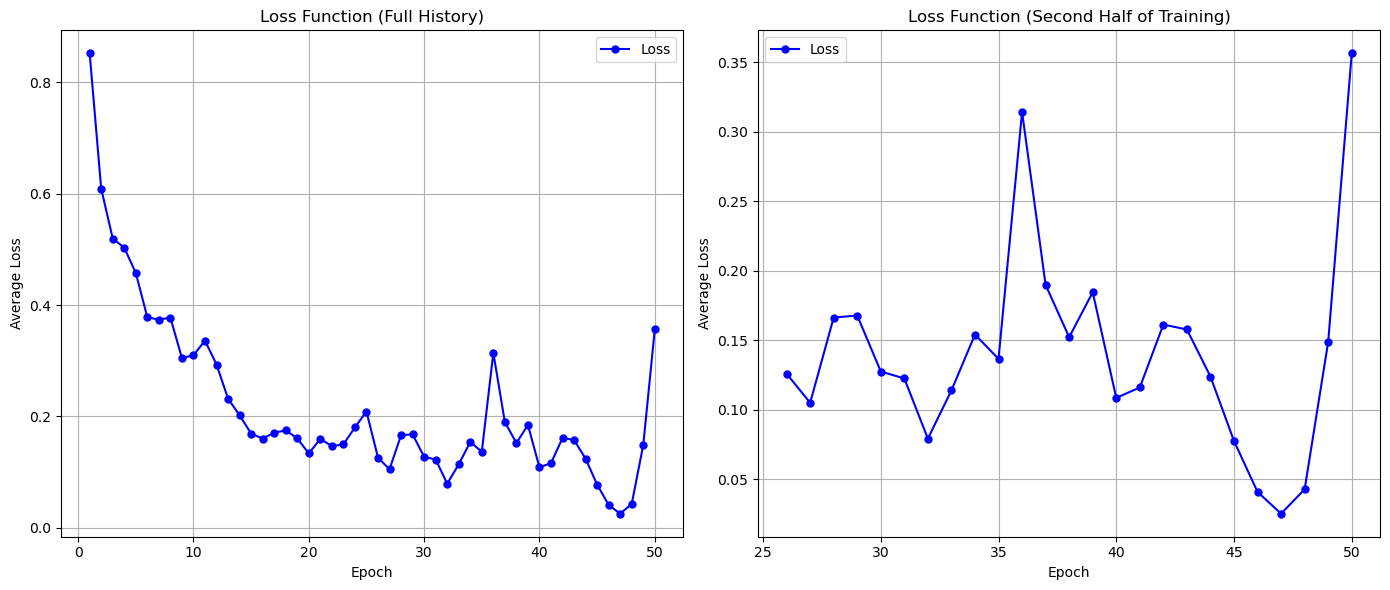

In [54]:
trainer.plot_training_history()

#### Оценка

In [55]:
trainer.evaluate(cifar100_001)

Classification report for train dataset:
              precision    recall  f1-score   support

    wardrobe     0.9579    0.9560    0.9570       500
  chimpanzee     0.8965    0.9180    0.9071       500
    mushroom     0.9284    0.9080    0.9181       500

    accuracy                         0.9273      1500
   macro avg     0.9276    0.9273    0.9274      1500
weighted avg     0.9276    0.9273    0.9274      1500

--------------------------------------------------
Classification report for test dataset:
              precision    recall  f1-score   support

    wardrobe     0.8165    0.8900    0.8517       100
  chimpanzee     0.7609    0.7000    0.7292       100
    mushroom     0.7374    0.7300    0.7337       100

    accuracy                         0.7733       300
   macro avg     0.7716    0.7733    0.7715       300
weighted avg     0.7716    0.7733    0.7715       300

--------------------------------------------------


#### Сохранение модели в ONNX

In [57]:
trainer.save_model(cifar100_001)

Model saved as: cifar100_ad0c809b-5287-4e5b-bed3-262c079f0638.onnx
Model UUID: ad0c809b-5287-4e5b-bed3-262c079f0638


### Эксперимент №2

#### Гиперпараметры

In [ ]:
batch_size=2**5
epochs=50
criterion=nn.NLLLoss()
lr_rate = 1e-4
layers=[32, 64, 128, 64, 32]

#### Инициализация модели

In [ ]:
%%time
trainer = CIFAR100Trainer(CLASSES, batch_size, lr_rate)

In [ ]:
%%time
cifar100_001 = CIFAR100Model(layers)

#### Информация о модели

In [ ]:
cifar100_001

#### Обучение

In [ ]:
%%time
trainer.train(cifar100_001, epochs)

In [ ]:
trainer.plot_training_history()

#### Оценка

In [ ]:
trainer.evaluate(cifar100_001)

#### Сохранение модели в ONNX

In [ ]:
trainer.save_model(cifar100_001)

### Эксперимент №3

#### Гиперпараметры

In [ ]:
batch_size=2**5
epochs=30
criterion=nn.NLLLoss()
lr_rate = 1e-5
# criterion=nn.CrossEntropyLoss()
layers=[32, 64, 128, 64, 32]

#### Инициализация модели

In [ ]:
%%time
trainer = CIFAR100Trainer(CLASSES, batch_size, lr_rate)

In [ ]:
%%time
cifar100_001 = CIFAR100Model(layers)

#### Информация о модели

In [ ]:
cifar100_001

#### Обучение

In [ ]:
%%time
trainer.train(cifar100_001, epochs)

In [ ]:
trainer.plot_training_history()

#### Оценка

In [ ]:
trainer.evaluate(cifar100_001)

#### Сохранение модели в ONNX

In [ ]:
trainer.save_model(cifar100_001)

### Эксперимент №4

#### Гиперпараметры

In [ ]:
batch_size=2**5
epochs=100
criterion=nn.CrossEntropyLoss()
lr_rate = 1e-4
layers=[32, 64, 128, 64, 32]

#### Инициализация модели

In [ ]:
%%time
trainer = CIFAR100Trainer(CLASSES, batch_size, lr_rate)

In [ ]:
%%time
cifar100_001 = CIFAR100Model(layers)

#### Информация о модели

In [ ]:
cifar100_001

#### Обучение

In [ ]:
%%time
trainer.train(cifar100_001, epochs)

In [ ]:
trainer.plot_training_history()

#### Оценка

In [ ]:
trainer.evaluate(cifar100_001)

#### Сохранение модели в ONNX

In [ ]:
trainer.save_model(cifar100_001)

### Эксперимент №5

#### Гиперпараметры

In [ ]:
batch_size=2**5
epochs=100
criterion=nn.CrossEntropyLoss()
lr_rate = 1e-5
layers=[32, 64, 128, 64, 32]

#### Инициализация модели

In [ ]:
%%time
trainer = CIFAR100Trainer(CLASSES, batch_size, lr_rate)

In [ ]:
%%time
cifar100_001 = CIFAR100Model(layers)

#### Информация о модели

In [ ]:
cifar100_001

#### Обучение

In [ ]:
%%time
trainer.train(cifar100_001, epochs)

In [ ]:
trainer.plot_training_history()

#### Оценка

In [ ]:
trainer.evaluate(cifar100_001)

#### Сохранение модели в ONNX

In [ ]:
trainer.save_model(cifar100_001)